In [8]:
% matplotlib notebook

## Crabtree positive organisms
### (_by Ignatius van Rooyen_)

In 1931 Heinrich Warburg received the Nobel price for his work on cancer. Today the cause of the [Warburg effect](https://en.wikipedia.org/wiki/Warburg_effect_(oncology) is still widely debated. The biochemist Herman Crabtree discovered that the bread/wine yeast _Saccharomyces cerevisiae_ behaves in a similar manner to cancer cells, where fermentation pathways (ethanol or lactic acid) are employed in combination with the respiratory pathways when the carbon substrate (like glucose) is freely available. So this implies that _S. cerevisiae_ produces ethanol in aerobic conditions. There are numerous ways to interpret the Crabtree effect, but ultimately it boils down to a limit in mitochondrial activity. The cells exhibit a maximum respiratory capacity that is not induced by an oxygen limitation like the example in Tut 11. Given that the cells are able to take up vast amounts of glucose, more ATP can be obtained by employing the fermentative pathways in the cytosol.

In this tutorial we'll model _S. cerevisiae_ under aerobic conditions where oxygen mass transfer limitations are not considered (we'll assume a massive sparging rate in the fermenter). We will also look at the commercial process where _S. cerevisiae_ is produced for the baking industry. In this process the objective is to limit ethanol formation since ethanol will reduce the yield of biomass on glucose.

For the yeast in this study you can assume a maximum mitochondrial ATP production rate of $0.25 \frac{cmol ATP}{cmol\,X\cdot h}$. The flux model is the same as before and is given below:

<img src="etresp.png" width="650" />

The following physiological parameters will be used:


|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$| $(P/O)$ $\qquad \qquad$
|----|-|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$|$\frac{mol\,ATP}{mol\, O}$
|0.05|2.3|0.25|0.15|1.5

Let's assume the standard biomass formula of $CH_{1.8}O_{0.5}N_{0.2}$.

The growth and maintenance functions are given below:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1-\frac{C_e}{C_e^*} \right]$$

$$\theta=\theta_{max}\left[\frac{Cs}{Km+Cs}\right]$$

Parameters are defined in the cell below:



In [9]:
Cemax, Km= 2.5, 0.01

In [10]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
alpha, gamma, PO = 0.05, 2.3, 1.5
mumax, thetamax = 0.25, 0.15

In [11]:
#                   S  N    X  C  W  NADH
S = np.matrix([    [1, 0,   1, 1, 0, 0],   # C
                   [2, 3, 1.8, 0, 2, 2],   # H
                   [1, 0, 0.5, 2, 1, 0],   # O
                   [0, 1, 0.2, 0, 0, 0],   # N
                   [0, 0,   1, 0, 0, 0],   # rX = 1
                   [0, 0,   0, 1, 0, 0]    # rCO2 = alpha
                     ])
C = np.matrix([0,0,0,0,1,alpha]).T
r = np.linalg.solve(S,C)
print(r.round(4))

[[-1.05]
 [-0.2 ]
 [ 1.  ]
 [ 0.05]
 [ 0.45]
 [-0.  ]]


In [12]:
beta = r[5,0]
print(beta)
# Let beta = 0
beta = 0

-5.55111512313e-17


- ATP Production
  - Glycolysis                = in cytosol of cell
  - TCA cycle                 = in matrix of mitochondria
  - Oxidative Phosphorylation = in mitochondria

Therefore, mitochondrial ATP production occurs via r2 (TCA) and r6 (Oxidative Phosphorylation)

a) What is the maximum pyruvate flux to the TCA cycle? [$ 0.068\frac{cmol ATP}{cmol\,X\cdot h}$]

b) Incorperate the Crabtree effect in your flux model and generate the relevant concentration profiles.

<img src="crabtree1.png" width="450" />

In [13]:
def resp_fun(C):
    Cx, Cs, Ce = C[0], C[1], C[2]
    mu = mumax * (Cs / (Cs + Km)) * (1 - Ce / Cemax)
    theta = thetamax * (Cs / (Km + Cs))
    
    #                r0,       r1,   r2,   r3,   r4,  r5,   r6
    M = np.matrix([ [-1, (1+alpha),   1,    1,    0,   0,    0],  # Node
                    [ 0,         0,   0,   -1,    1, 1.5,    0],  # Node
                    [ 0,      beta,   2,    0, -1/3,   0,   -2],  # NADH
                    [ 0,  -1*gamma, 2/3, -1/3,    0,   1, 2*PO],  # ATP = theta
                    [ 0,         1,   0,    0,    0,   0,    0],  # Basis = r1 = mu
                    [ 0,         0,   0,    0,    1,   0,    0],  # From Tut 11 = rGly = r4 = 0              
                                                                  ])
    
    # ATP produced via aerobic respiration ie. TCA and Oxidative Phosphorylation = No fermentation => rEtOH = 0
    M1 = np.vstack( [M, 
                    [ 0, 0, 0, 0, 0, 1, 0] ])     # rEtOH = r5 = 0
    C1 = np.matrix([0,0,0, theta, mu, 0, 0]).T
    r1 = np.linalg.solve(M1, C1)
    
    #                    TCA        Oxidative Phosphorylation    
    rATP_mit = ((2/3) * r1[2,0]) + (2 * PO * r1[6,0])    # molATP / cmolX.h
    
    if rATP_mit < 0.25:
        return [  r1[1,0],    # rX = r1
                 -r1[0,0],    # rS = r0
                  r1[5,0]  ]  # rE = r5
    
    else:   # ATP produced via fermentation by limiting rATP_mit to 0.25 ie. EtOH formation occurs 
        M2 = np.vstack([ M,  # r2             r6
                        [0, 0, 2/3, 0, 0, 0, 2*PO]  ])  # max ATP produced via mitochondria = 0.25           
        C2 = np.matrix([0,0,0, theta, mu, 0, 0.25]).T
        r2 = np.linalg.solve(M2, C2)

        return [  r2[1,0],    # rX = r1
                 -r2[0,0],    # rS = r0
                  r2[5,0]  ]  # rE = r5

In [14]:
def batch_ferm(C, t):
    Cx = C[0]
    r = resp_fun(C)
    rx, rs, re = r[0], r[1], r[2]
    eq1 = rx*Cx
    eq2 = rs*Cx
    eq3 = re*Cx
    return [eq1, eq2, eq3]

<IPython.core.display.Javascript object>


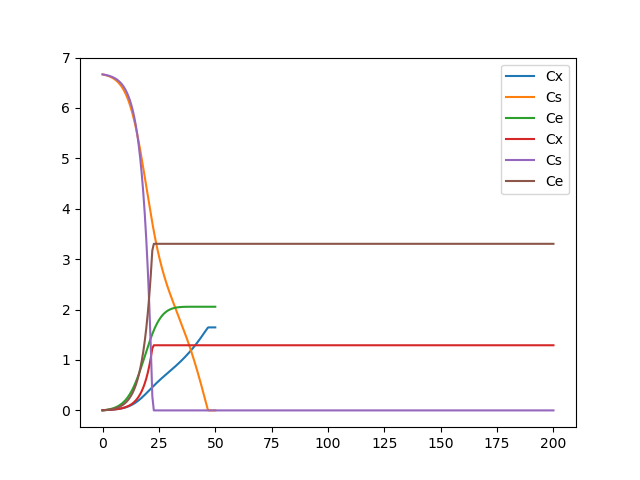

In [15]:
Cxo = 0.005  #cmol X/L
Cso = 200/30 #cmol S/L
Ceo = 0
Co = [Cxo, Cso, Ceo]
tspan = np.linspace(0, 50, 300)
Ci = odeint(batch_ferm, Co, tspan)
Cx, Cs, Ce = Ci.T
plt.figure(1)
plt.plot(tspan, Cx, label = 'Cx')
plt.plot(tspan, Cs, label = 'Cs')
plt.plot(tspan, Ce, label = 'Ce')
plt.legend(loc = 'best')

c) Why does ethanol formation terminate towards the end?

- Starts out with max ATP and as glucose gets depleted, the ATP production is below maximum

d) Plot $\mu$ as a function of time and explain.

<img src="crabtree2.png" width="450" />


<IPython.core.display.Javascript object>


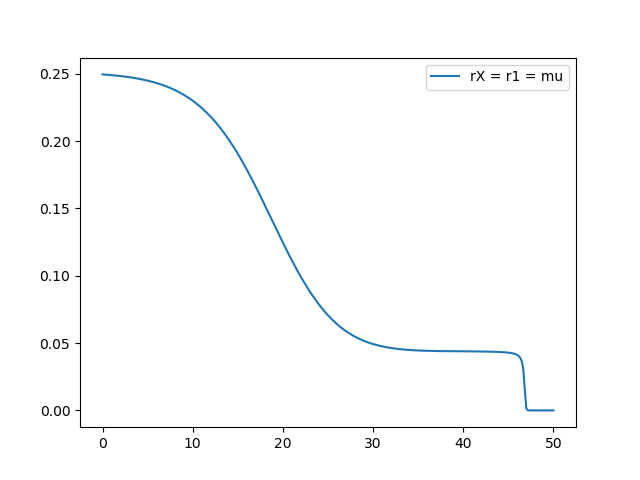

In [16]:
r = np.asarray([resp_fun(C) for C in Ci])
rx = r[:,0]
plt.figure(2)
plt.plot(tspan, rx, label = 'rX = r1 = mu')
plt.legend(loc = 'best')

- mu decreases as time progresses
- 

e) Rerun the fermentation but add 2 $\frac{cmol}{L}$ of ethanol at the start. How long does it take to complete the fermentation? Does additional ethanol form and why? [136 h]


<IPython.core.display.Javascript object>


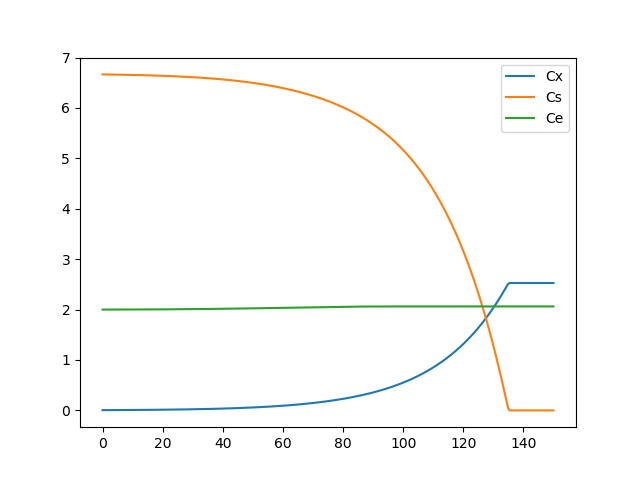

In [17]:
Ceo = 2      #cmol E/L
Co = [Cxo, Cso, Ceo]
tspan = np.linspace(0, 150, 300)
Ci = odeint(batch_ferm, Co, tspan)
Cx, Cs, Ce = Ci.T
plt.figure(3)
plt.plot(tspan, Cx, label = 'Cx')
plt.plot(tspan, Cs, label = 'Cs')
plt.plot(tspan, Ce, label = 'Ce')
plt.legend(loc = 'best')

- It takes 136 hours for the fermentation to complete
- No additional EtOH forms
- This is probably due to the fact that there is an abundance of EtOH surrounding the microbe
- To maintain equilibrium with its environment, the microbe does not produce additional EtOH
- Less ATP is produced via the fermentative pathway and as a result, the process takes longer to achieve

f)  You are employed to produce this yeast for a bakery. You decide to use a fed-batch reactor with a constant feed of glucose. Starting with the same inoculum concentration of biomass and zero glucose in a 50 liter fermenter you add a syrup of 400 $\frac{g}{L}$ to the fermenter at a chosen constant feed rate. The fermenter cannot exceed a final volume of 100 liter, so your final time will be a function of the chosen flowrate. The objective is to maximise the yield of biomass on glucose in the shortest possible fermentation time. Plot $\mu$ for all your attempts and analyse. Convince yourself that the maximum possible yield is 0.465 $\frac{g}{g}$. Start with a feedrate of 1 $\frac{L}{h}$.

<img src="crabtree3.png" width="450" />

In [21]:
def fed_batch(N, t):
    V = N[3]
    Nx, Ns, Ne = N[0], N[1], N[2]
    Cx, Cs, Ce = Nx/V, Ns/V, Ne/V
    C = [Cx, Cs, Ce]
    r = resp_fun(C)
    rx, rs, re = r[0], r[1], r[2]
    
    dNxdt = rx*Cx*V
    dNsdt = Qf*Csf + rs*Cx*V
    dNedt = re*Cx*V
    dVdt  = Qf
    
    return [dNxdt, dNsdt, dNedt, dVdt]  # Complete this on your own 

In [46]:
Cxo = 0.005
Cso = 0
Csf = 400/30  # cmol/L
Vol = 50      # L
Qf = 0.00525        # L/h

<IPython.core.display.Javascript object>


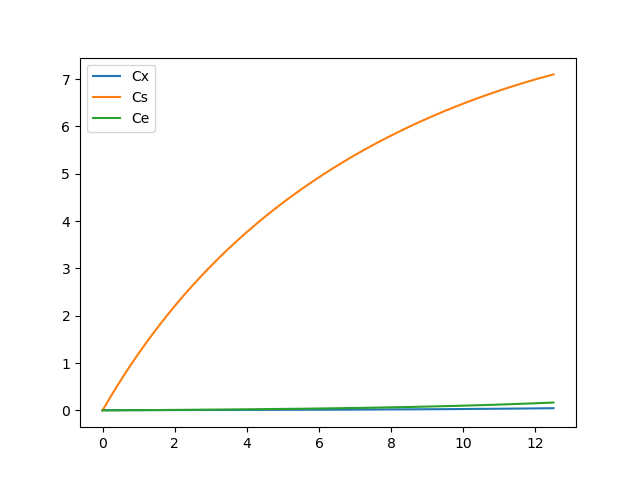

In [44]:
Nso, Nxo = Cso*Vol , Cxo*Vol
No = [Nxo, Nso, 0, Vol]
tspan = np.linspace(0, 12.5, 300)
Ni = odeint(fed_batch, No, tspan)
Vt = Ni[:,3]
Nx, Ns, Ne = Ni[:,0], Ni[:,1], Ni[:,2]
Cx, Cs, Ce = Nx/Vt, Ns/Vt, Ne/Vt
plt.figure(4)
plt.plot(tspan, Cx, label = 'Cx')
plt.plot(tspan, Cs, label = 'Cs')
plt.plot(tspan, Ce, label = 'Ce')
plt.legend(loc = 'best')
#plt.axis([0,50,0,3])

In [45]:
Cx_end = Cx[-1]
Cs_end = Cs[-1]
Yxs = (Cx_end / Cs_end)  # cmol X / cmol S
Yxs = Yxs * (24.6/30)  # g X / g S
print(Yxs)

0.00536273720948


g) To further improve the productivity, it is suggested that you can use the spectrophotometric reading of the biomass concentration to adjust the flowrate with time. Use a proportional constant ($Q=kC_X$) and investigate. 

# ST

In [72]:
def resp_fun2(C):
    Cx, Cs, Ce = C[0], C[1], C[2]
    mu = mumax * (Cs / (Cs + Km)) 
    theta = 0
    
    #                r0,       r1,   r2,   r3,   r4,  r5,   r6
    M = np.matrix([ [-1, (1+alpha),   1,    1,    0,   0,    0],  # Node
                    [ 0,         0,   0,   -1,    1, 1.5,    0],  # Node
                    [ 0,      beta,   2,    0, -1/3,   0,   -2],  # NADH
                    [ 0,  -1*gamma, 2/3, -1/3,    0,   1, 2*PO],  # ATP = theta
                    [ 0,         1,   0,    0,    0,   0,    0],  # Basis = r1 = mu
                    [ 0,         0,   0,    0,    1,   0,    0],  # From Tut 11 = rGly = r4 = 0              
                                                                  ])
    
    # ATP produced via aerobic respiration ie. TCA and Oxidative Phosphorylation = No fermentation => rEtOH = 0
    M1 = np.vstack( [M, 
                    [ 0, 0, 0, 0, 0, 1, 0] ])     # rEtOH = r5 = 0
    C1 = np.matrix([0,0,0, theta, mu, 0, 0]).T
    r1 = np.linalg.solve(M1, C1)
    
    #                    TCA        Oxidative Phosphorylation    
    rATP_mit = ((2/3) * r1[2,0]) + (2 * PO * r1[6,0])    # molATP / cmolX.h
    
    if rATP_mit < 0.25:
        return [  r1[1,0],    # rX = r1
                 -r1[0,0],    # rS = r0
                  r1[5,0]  ]  # rE = r5
    
    else:   # ATP produced via fermentation by limiting rATP_mit to 0.25 ie. EtOH formation occurs 
        M2 = np.vstack([ M,  # r2             r6
                        [0, 0, 2/3, 0, 0, 0, 2*PO]  ])  # max ATP produced via mitochondria = 0.25           
        C2 = np.matrix([0,0,0, theta, mu, 0, 0.25]).T
        r2 = np.linalg.solve(M2, C2)

        return [  r2[1,0],    # rX = r1
                 -r2[0,0],    # rS = r0
                  r2[5,0]  ]  # rE = r5

In [73]:
def batch_ferm2(C, t):
    Cx = C[0]
    r = resp_fun2(C)
    rx, rs, re = r[0], r[1], r[2]
    eq1 = rx*Cx
    eq2 = rs*Cx
    eq3 = re*Cx
    return [eq1, eq2, eq3]

<IPython.core.display.Javascript object>


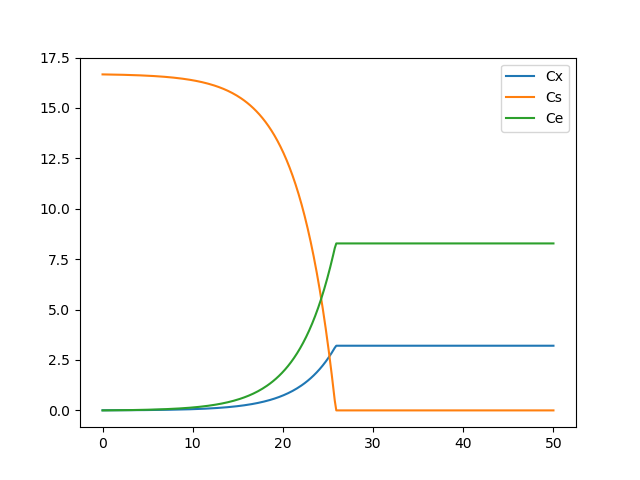

In [78]:
Cxo = 0.005  #cmol X/L
Cso = 500/30 #cmol S/L
Ceo = 0
Co = [Cxo, Cso, Ceo]
tspan = np.linspace(0, 50, 300)
Ci = odeint(batch_ferm2, Co, tspan)
Cx, Cs, Ce = Ci.T
plt.figure(10)
plt.plot(tspan, Cx, label = 'Cx')
plt.plot(tspan, Cs, label = 'Cs')
plt.plot(tspan, Ce, label = 'Ce')
plt.legend(loc = 'best')

<IPython.core.display.Javascript object>


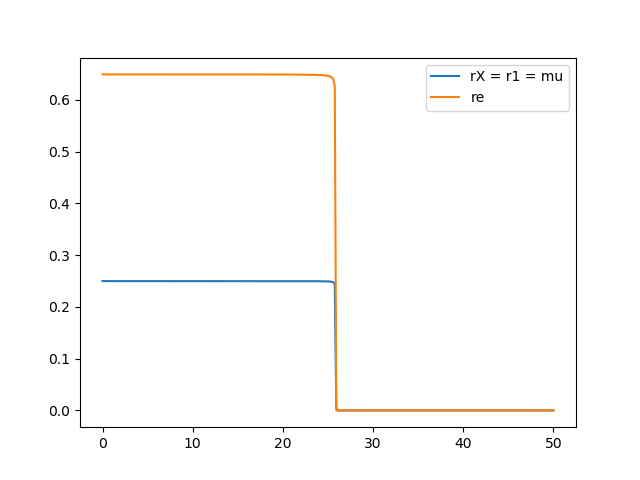

In [79]:
r = np.asarray([resp_fun2(C) for C in Ci])
rx = r[:,0]
re = r[:,2]
plt.figure(11)
plt.plot(tspan, rx, label = 'rX = r1 = mu')
plt.plot(tspan, re, label = 're')
plt.legend(loc = 'best')